<a href="https://colab.research.google.com/github/chen-star/llm_model_trainings/blob/main/5_1_fine_tuning_writing_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ⭐ Fine-tuning ⭐

---

🚆 Fine-tuning the the model GPT-neo

Fine tuning pre-trained GPT-neo to learn the different writing styles from 2 books: << Romeo and Juliet >> and << Alice's Adventures in Wonderland >>.

---

# ✈ Imports

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

!pip install torchinfo
from torchinfo import summary

import requests
from typing import override

# 🔢 Hyperparameters

In [2]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
batch_size = 8

context_window_size = 512

# 📂 Prepare Training Data

In [4]:
# import GPT-neo tokenizer
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125m')
tokenizer.pad_token_id = tokenizer.encode(' ')[0]

In [5]:
# download << Romeo and Juliet >>
romeo_and_juliet_text = requests.get('https://www.gutenberg.org/cache/epub/1513/pg1513.txt').text
romeo_and_juliet_token_ids = torch.tensor( tokenizer.encode(romeo_and_juliet_text),dtype=torch.long )
print(f'<romeo_and_juliet> Token size: {len(romeo_and_juliet_token_ids)}')

Token indices sequence length is longer than the specified maximum sequence length for this model (56185 > 2048). Running this sequence through the model will result in indexing errors


<romeo_and_juliet> Token size: 56185


In [6]:
# download << Alice's Adventures in Wonderland  >>
alice_text = requests.get('https://www.gutenberg.org/cache/epub/11/pg11.txt').text
alice_token_ids = torch.tensor( tokenizer.encode(alice_text),dtype=torch.long )
print(f'<alice> Token size: {len(alice_token_ids)}')

<alice> Token size: 52954


# [0] 🏚 Model

In [7]:
# import GPT-neo model for each book
romeo_and_juliet_model = AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125m').to(device)
alice_model = AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125m').to(device)

In [8]:
# inspect the before-fine-tuning model
alice_model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

# [1] 🔘 Fine-tuning

In [9]:
# optimizers
romeo_and_juliet_optimizer = torch.optim.AdamW(romeo_and_juliet_model.parameters(), lr=5e-5, weight_decay=.01)
alice_optimizer = torch.optim.AdamW(alice_model.parameters(), lr=5e-5, weight_decay=.01)

In [10]:
# init losses
romeo_and_juliet_loss = []
alice_loss = []

In [11]:
sample_size = 300


for i in range(sample_size):

  # ----- Fine-turning `romeo_and_juliet_model` -----
  # get input data X
  random_idx = torch.randint(len(romeo_and_juliet_token_ids)-context_window_size, (batch_size,))
  X  = romeo_and_juliet_token_ids[random_idx[:,None] + torch.arange(context_window_size)].to(device)

  # clear previous gradients
  romeo_and_juliet_model.zero_grad(set_to_none=True)

  # forward
  # loss calc is handled in model internally
  outputs = romeo_and_juliet_model(X, labels=X)

  # back propagate
  outputs.loss.backward()
  romeo_and_juliet_optimizer.step()

  # save loss
  romeo_and_juliet_loss.append(outputs.loss.item())
  # --------------------------------------------------



  # ----- Fine-turning `alice_model` -----
  # get input data X
  random_idx = torch.randint(len(alice_token_ids)-context_window_size, (batch_size,))
  X  = alice_token_ids[random_idx[:,None] + torch.arange(context_window_size)].to(device)

  # clear previous gradients
  alice_model.zero_grad(set_to_none=True)

  # forward
  # loss calc is handled in model internally
  outputs = alice_model(X, labels=X)

  # back propagate
  outputs.loss.backward()
  alice_optimizer.step()

  # save loss
  alice_loss.append(outputs.loss.item())
  # --------------------------------------------------

  if i % 50 == 0:
    print(f"Iteration {i}/{sample_size}: Romeo and Juliet Loss = {romeo_and_juliet_loss[-1]:.4f}, Alice Loss = {alice_loss[-1]:.4f}")

Iteration 0/300: Romeo and Juliet Loss = 3.0128, Alice Loss = 2.4154
Iteration 50/300: Romeo and Juliet Loss = 2.5632, Alice Loss = 1.7217
Iteration 100/300: Romeo and Juliet Loss = 2.0730, Alice Loss = 1.5109
Iteration 150/300: Romeo and Juliet Loss = 1.7936, Alice Loss = 1.1624
Iteration 200/300: Romeo and Juliet Loss = 1.4242, Alice Loss = 0.6900
Iteration 250/300: Romeo and Juliet Loss = 0.8144, Alice Loss = 0.5949


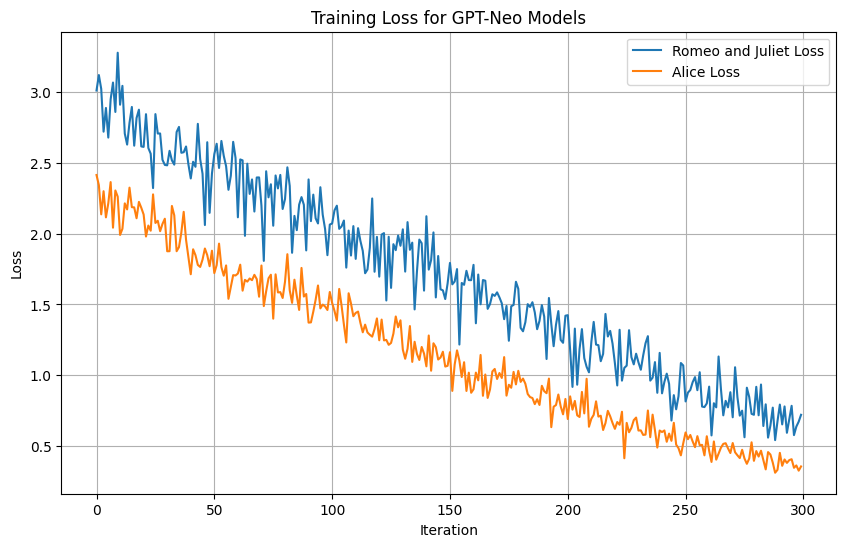

In [12]:
# plot the losses
plt.figure(figsize=(10, 6))
plt.plot(romeo_and_juliet_loss, label='Romeo and Juliet Loss')
plt.plot(alice_loss, label='Alice Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss for GPT-Neo Models')
plt.legend()
plt.grid(True)
plt.show()

# [2] 🧪 Evaluation of Fine-tuned models

### Quanlitative

Given a same prompt, generate different writing-style text...

In [20]:
# Qualitative
prompt = "Once upon a time"
print()

print('--- Generating text from Romeo and Juliet model ---')
input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
output = romeo_and_juliet_model.generate(input_ids, max_length=100, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, temperature=0.7)
print(tokenizer.decode(output[0], skip_special_tokens=True))

print('\n--- Generating text from Alice model ---')
output = alice_model.generate(input_ids, max_length=100, num_return_sequences=1, do_sample=True, top_k=50, top_p=0.95, temperature=0.7)
print(tokenizer.decode(output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Generating text from Romeo and Juliet model ---


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Once upon a time,
The sun and moon, lovers and betimes,
We married, and then the earth smil,
But this night she blow’d at our door,
And then we parted, and she made a vow.
This she shall live with all the earth,
And her death shall doom her to eternal exile.

LADY CAPULET.
O love, O, that I lov

--- Generating text from Alice model ---
Once upon a time, there lived a
frightful sort of a house, and after a fashion that everybody
called frightful, it slowly got down from the roof, and came
saying to one of the trees, “Let me out of sight!”

The tree behind it was very frightened; it looked as if some large
animals would eat this way: so, when it got its head down, it began



#### Quantitative: Perplexity

Perplexity is a measure of how well a probability distribution or language model predicts a sample. A lower perplexity score indicates that the model is better at predicting the next word in a sequence, given the previous words.

In simpler terms, a lower perplexity means the model is more confident and accurate in its predictions, making it a better language model for the given text.

In [23]:
# Prepare train / test dataset

split_ratio = 0.8 # 80% for training, 20% for validation

# Split Romeo and Juliet token IDs
romeo_and_juliet_split_idx = int(len(romeo_and_juliet_token_ids) * split_ratio)
romeo_and_juliet_train_ids = romeo_and_juliet_token_ids[:romeo_and_juliet_split_idx]
romeo_and_juliet_test_ids = romeo_and_juliet_token_ids[romeo_and_juliet_split_idx:]

print(f"Romeo and Juliet train set size: {len(romeo_and_juliet_train_ids)}")
print(f"Romeo and Juliet validation set size: {len(romeo_and_juliet_test_ids)}")
print(f"Romeo and Juliet train / test: {len(romeo_and_juliet_train_ids) / len(romeo_and_juliet_test_ids)}")

# Split Alice token IDs
alice_split_idx = int(len(alice_token_ids) * split_ratio)
alice_train_ids = alice_token_ids[:alice_split_idx]
alice_test_ids = alice_token_ids[alice_split_idx:]

print(f"Alice train set size: {len(alice_train_ids)}")
print(f"Alice validation set size: {len(alice_test_ids)}")
print(f"Alice train / test: {len(alice_train_ids) / len(alice_test_ids)}")

Romeo and Juliet train set size: 44948
Romeo and Juliet validation set size: 11237
Romeo and Juliet train / test: 4.0
Alice train set size: 42363
Alice validation set size: 10591
Alice train / test: 3.999905580209612


In [28]:
# Perplexity is calculated as: PPL = exp(cross_entropy_loss)

def calculate_perplexity(model, tokenized_text_data, batch_size, context_window_size, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    num_batches = 0

    # Iterate through the tokenized text data in batches
    # The last batch might be smaller than context_window_size, so handle it.
    # We need at least context_window_size + 1 tokens for input and label
    # because labels are shifted internally in CausalLM models.
    for i in range(0, len(tokenized_text_data) - context_window_size -1, batch_size):
        batch_end = i + batch_size
        # Ensure we don't go out of bounds and have enough data for context_window_size
        if batch_end * context_window_size > len(tokenized_text_data):
            break # Stop if we can't form a full batch of context_window_size

        # Create input tensors for the current batch
        # We need to extract context_window_size tokens for each sample in the batch
        batch_input_ids = []
        for j in range(batch_size):
            start_idx = i + j * context_window_size
            end_idx = start_idx + context_window_size
            if end_idx > len(tokenized_text_data):
                break
            batch_input_ids.append(tokenized_text_data[start_idx:end_idx])

        if not batch_input_ids: # If no full segments could be formed for this batch
            break

        input_ids = torch.stack(batch_input_ids).to(device)

        with torch.no_grad():  # Disable gradient calculations
            outputs = model(input_ids, labels=input_ids) # Labels are the same as input for CausalLM
            # Internally, CausalLM models calculate cross-entropy loss by comparing
            # the predicted logits for the next token against the actual next token (from labels).
            # The `labels` are shifted inside the model so that `labels[i]` is used as the target for `logits[i]`.
            # The loss is then averaged over the sequence and batch.
            loss = outputs.loss
            total_loss += loss.item()
            num_batches += 1

    if num_batches == 0:
        return float('inf') # Return infinity if no batches were processed

    average_loss = total_loss / num_batches
    perplexity = torch.exp(torch.tensor(average_loss))
    return perplexity.item()

Calculate perplexity for both models...

In [29]:
romeo_and_juliet_perplexity = calculate_perplexity(
    romeo_and_juliet_model,
    romeo_and_juliet_test_ids,
    batch_size,
    context_window_size,
    device
)
print(f"Romeo and Juliet model perplexity on validation set: {romeo_and_juliet_perplexity:.2f}")

Romeo and Juliet model perplexity on validation set: 2.20


In [30]:
alice_perplexity = calculate_perplexity(
    alice_model,
    alice_test_ids,
    batch_size,
    context_window_size,
    device
)
print(f"Alice model perplexity on validation set: {alice_perplexity:.2f}")

Alice model perplexity on validation set: 1.43


**Interpret Results**

Comparing the scores, the **Alice model has a lower perplexity (1.43) than the Romeo and Juliet model (2.20)**. This indicates that the Alice model better predicts its corresponding text (Alice's Adventures in Wonderland) on the validation set compared to how well the Romeo and Juliet model predicts its text.

Therefore, the **Alice model demonstrates better predictive power** for its target text based on these perplexity scores.